In [1]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from bc_power import utils, hydro
import pandas as pd
from shapely.geometry import Point
import pypsa
import numpy as np
import atlite
import pyomo
import matplotlib.pyplot as plt
import math
# from pypsa.networkclustering import get_clustering_from_busmap
import matplotlib.dates as mdates
import cartopy.crs as ccrs

pyomo.__version__

'6.5.0'

In [5]:
gwa_ts_path = "/home/pmcwhannel/repos/PyPSA_BC/data/expansion/GWA_Cells_ALL_buckets_CF_timeseries.pkl"
gwa_sites_path = "/home/pmcwhannel/repos/PyPSA_BC/data/expansion/GWA_cells_ALL_buckets_withoutCFts.pkl"
gwa_sites = utils.read_pickle(gwa_sites_path)
gwa_ts = utils.read_pickle(gwa_ts_path)

In [8]:
pv_ts_path = "/home/pmcwhannel/repos/PyPSA_BC/data/expansion/Solar_Top_Sites_Clustered_CF_timeseries.pkl"
pv_sites_path = "/home/pmcwhannel/repos/PyPSA_BC/data/expansion/Solar_Top_Sites_Clustered.pkl"
pv_sites = utils.read_pickle(pv_sites_path)
pv_ts = utils.read_pickle(pv_ts_path)

In [11]:
pv_sites['capex'].iloc[0] * 1000000

901.4853121307063

### Merging shapely polygons

In [ ]:
gdf = gpd.read_file("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/regions/gadm41_CAN_1.json")
mask = gdf['NAME_1'] == "BritishColumbia"
west_lon = gdf[mask].geometry.bounds['minx'].iloc[0]
south_lat = gdf[mask].geometry.bounds['miny'].iloc[0]
east_lon = gdf[mask].geometry.bounds['maxx'].iloc[0]
north_lat = gdf[mask].geometry.bounds['maxy'].iloc[0]

In [ ]:
bbox = (west_lon, south_lat, east_lon, north_lat)
polygon_1 = shapely.geometry.box(*bbox, ccw=True)

bbox_2 = (west_lon-5, south_lat-5, east_lon-5, north_lat-5)
polygon_2 = shapely.geometry.box(*bbox_2, ccw=True)

polys = [polygon_1, polygon_2]

gpd.GeoSeries(polys).boundary.plot()

In [ ]:
west_lon,south_lat,east_lon ,north_lat

### Loading configuration file and testing extraction of year

In [ ]:
config_file = r"/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)

In [ ]:
start_year = cfg['cutout']["snapshots"]["start"][0][:4]
end_year = cfg['cutout']["snapshots"]["end"][0][:4]

In [ ]:
prefix = cfg['cutout']['path'] + cfg['cutout']['region']["name"]
suffix = "2021" + ".nc"

"_".join([prefix, suffix])

### Loading BC Hydro Load Data and Community Energy and Emissions Inventory

In [ ]:
bch = pd.read_csv("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/BCH/BalancingAuthorityLoad2020.csv")
ceei_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/CEEI/bc_utilities_energy_and_emissions_data_at_the_community_level.xlsx"
ceei_bch = pd.read_excel(ceei_path,sheet_name="BC Hydro")
ceei_fbc_elec = pd.read_excel(ceei_path,sheet_name="FBC Elec") # Will not use data prior to 2013 otherwise need to pull Kelowna records too
ceei_nw = pd.read_excel(ceei_path,sheet_name="NewWest")
ceei_nel = pd.read_excel(ceei_path,sheet_name="NelsonHydro")
ceei_gf = pd.read_excel(ceei_path,sheet_name="GrandForks")
ceei_pen = pd.read_excel(ceei_path,sheet_name="Penticton")
ceei_sl = pd.read_excel(ceei_path,sheet_name="Summerland")
ceei_prc = pd.read_excel(ceei_path,sheet_name="Princeton")
ceei_yk = pd.read_excel(ceei_path,sheet_name="YukonElec")

In [ ]:
elc_col = "CONSUMPTION_TOTAL" # Units of KW-hr
ceei_list = [ceei_bch, ceei_fbc_elec, ceei_nw, ceei_nel, ceei_gf, ceei_pen, ceei_sl, ceei_prc, ceei_yk] # ceei_fbc_elec
year = 2020
tot = 0 # capture total electricity demand in MW-hr for all ELC demands in the dataset
for df in ceei_list:
    mask = (df['YEAR'] == year) & ((df['ORG_TYPE'] != "Province") | (df["SOURCE"] != "BC Hydro"))
    tot += df[mask][elc_col].sum() / 1000 # convert to MW-hr

ratio = bch['Balancing Authority Load'].sum() / tot
print(f"The ratio between the BC Hydro load data and CEEI load is {ratio}")

In [ ]:
bch['Balancing Authority Load']

### Thermal PP

In [ ]:
tpp_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generators.csv"
gen_gen_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generation_generic.csv"
df = pd.read_csv(tpp_path)
gen_params = pd.read_csv(gen_gen_path)

In [ ]:
tpp_gen_types = {'NG_CT', 'NG_CG', 'NG_CC', 'Gas_CT', 'Oil_CT', "Coal", 'Oil_ST', 'Diesel_CT', 'Coal_CCS'}
# BC has only NG_CC, NG_CG, NG_CT
mask = (df["province"] == "BC") & (df["gen_type"].apply(lambda x: x in tpp_gen_types ))
tpp = df[mask].copy()

In [ ]:
subset = ["connecting_node_code"]
sum_list = ["install_capacity_in_mw","annual_avg_energy_unit_in_gwh/y"]
tpp.groupby("connecting_node_code",group_keys=False).apply(lambda x: utils.merge_assets(x, subset, sum_list))

In [ ]:
tpp['gen_type']

In [ ]:
gen_params[gen_params['generation_type'] == "NG_CT"].iloc[0]['efficiency']

In [ ]:
gen_params.columns

In [ ]:
tpp['gen_type']

### Testing conceptual cascade in PyPSA
    i) 3 reservoir cascade
    ii) testing spill and discharge

In [ ]:
def get_multi_link_override():
    '''
    Gets the multi-link override. Needed for cascaded hydroelectric.
    '''
    # From PyPSA CHP Example: This ensures we can add 2 outputs for a single link i.e bus0 -> bus_1 AND bus_2
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        1.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    return override_component_attrs

def get_cascade_network(load_data, **kwargs):
    '''
    This function is going to replace function above. This function will feature a better design for adding links
    and other components when finished.
    '''
    # setup the network
    network = pypsa.Network(override_component_attrs=get_multi_link_override())
    network.set_snapshots(range(len(load_data)))
    
    network.add("Bus", "elc", carrier="AC")  # This likely will move
    network.add("Carrier", "water") # this may move since RoR also has water 
    network.add("Carrier", "inflow", co2_emissions=0.0) # likely will move
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    for res,components in kwargs.items():
        for name,params in components.items():
            network.add(**params)

    return network

def create_reservoir_dict(df, inflow_data, cascade_name="demo"):
    '''
    Accepts a dataframe of reservoirs and their parameters and
    ordering of the the reservoirs. This can be used to create dictionaries
    which will be used to instantiate the model of the reservoir.
    
    Modifications: Likely need to have inflow in csv files which
                   can be imported later.
    '''
    res_dict = {}
    for idx,row in df.iterrows():
        aid = row['asset_id']
        max_inflow = max(inflow_data[aid])
        res_dict[aid] = {}
        

        # 1) add water_bus
        res_dict[aid]['water bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"water bus"]),
                                          "carrier":"water",
                                        }

        # 2) add reservoir_bus
        res_dict[aid]['reservoir bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"reservoir bus"]),
                                          "carrier":"water",
                                        }

        # 3) add store_link
        res_dict[aid]['store link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"store link"]),
                                       "bus0": res_dict[aid]['water bus']['name'],
                                       "bus1": res_dict[aid]['reservoir bus']['name'],
                                       "efficiency":1., # mass balance
                                       "p_nom":1000000, # FIX: Should be derived to ensure larger than max(inflow + spill + discharge of any upstream reservoirs)
                                        } 
        
        # 4) get release_link
        res_dict[aid]['release link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"release link"]),
                                       "bus0": res_dict[aid]['reservoir bus']['name'],
                                       "bus1": res_dict[aid]['water bus']['name'],
                                       "efficiency":1., # mass_balance
                                       "p_nom":row["s_capacity"] + row['p_capacity'],
                                        } 
        

        # 5) get reservoir store
        res_dict[aid]['reservoir store'] = {"class_name":"Store",
                                            "name":" ".join([aid,"reservoir store"]),
                                            "bus":res_dict[aid]['reservoir bus']['name'],
                                            "e_nom":row["r_capacity"]
                                            }
        
        # 6) add inflow generator
        res_dict[aid]['inflow generator'] = {"class_name":"Generator",
                                            "name": " ".join([aid,"inflow generator"]),
                                            "bus": res_dict[aid]['reservoir bus']['name'],
                                            "carrier": "inflow",
                                            "efficiency":1., # mass_balance
                                            "p_nom":max_inflow, # max(inflow series)
                                            "p_set":inflow_data[aid],
                                            "p_max_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            "p_min_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            } 

        # Terminal check
        if type(row["downstream"]) == str: # not terminal
            downstream_aid = " ".join([row["downstream"],"water bus"])
        else: # terminal
            downstream_aid = " ".join([cascade_name,"water exit"])
            # Add bus for the terminal reservoir
            res_dict[aid]['terminal bus'] = {"class_name":"Bus",
                                                "name":downstream_aid,
                                                "carrier":"water",
                                                }
            
            # Add spill store
            res_dict[aid]['terminal store'] = {"class_name":"Store",
                                                "name":cascade_name,
                                                "bus":downstream_aid,
                                                "e_nom":10000000 # The max storage needs to retain all possible water in the model horizon
                                                }

        # 7) get discharge link
        res_dict[aid]['discharge link'] = {"class_name":"Link",
                                            "name": " ".join([aid,"discharge link"]),
                                            "bus0": res_dict[aid]['water bus']['name'],
                                            "bus1": row['elc_bus'],
                                            "bus2": downstream_aid,
                                            "marginal_cost":0.0001,
                                            "efficiency":row['p_capacity'] / row['q_rated'], # power conversion 
                                            "efficiency2":1., # mass balance
                                            "p_nom":row['q_rated'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                            } 
        # 8) get spill link
        res_dict[aid]['spill_link'] = {"class_name":"Link",
                                        "name": " ".join([aid,"spill link"]),
                                        "bus0": res_dict[aid]['water bus']['name'],
                                        "bus1": downstream_aid,
                                        "efficiency":1., # mass_balance
                                        "p_nom":row['s_capacity'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                        }

    return res_dict

In [ ]:
res_data = [["r1",1,1,10,0,"r2",np.nan,"elc"],
        ["r2",1,1,10,0,"r3","r1","elc"],
        ["r3",1,1,10,0,np.nan,"r2","elc"]]

inflow_data = {"r1":[10,10,10],"r2":[0,0,0],"r3":[0,0,0]} # {"aid":[inflow_series], ...}

load_data = [1,1,1]

# connecting_node_code will need to be added later
# upstream doesn't matter other than to find the head reservoir
# downstream doesn't matter other than to find the terminal reservoir
reservoirs = pd.DataFrame(res_data, columns=["asset_id","q_rated","p_capacity","s_capacity","r_capacity","downstream","upstream","elc_bus"]) 
res_dict = create_reservoir_dict(reservoirs, inflow_data)
network = get_cascade_network(load_data,**res_dict)
reservoirs.head()

In [ ]:
# network.lopf(pyomo=False, solver_logfile="tester.log");
network.optimize(solver_name='cbc')

# create subplots
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,8))
fig.suptitle('Process variables on conceptual cascade system') 
# SOC
ax_soc = network.stores_t.e.plot(ax=axes[0],marker='o')
ax_soc.set_ylabel('State of Charge (SOC) (m^3)')
ax_soc.set_title('SOC vs Time')

# water discharges
col_sel = ["r1 discharge link", "r2 discharge link", "r3 discharge link"]
ax_discharge = network.links_t.p0[col_sel].plot(ax=axes[1],marker='o')
ax_discharge.set_ylabel('Discharge (MW)')

# inflow 
ax_inflow = network.generators_t.p.plot(ax=axes[2],marker='o')
ax_inflow.set_ylabel('Inflow (m^3)')

# Formatting
ax_inflow.set_xticks([0,1,2])
ax_soc.set_xticks([0,1,2])
ax_discharge.set_xticks([0,1,2])

ax_soc.get_shared_x_axes().join(ax_soc, ax_discharge,ax_inflow)
ax_soc.set_xlabel("")
ax_discharge.set_xlabel("")
ax_soc.set_xticklabels([])
ax_discharge.set_xticklabels([])
# ax_soc.sharex(ax_soc, ax_discharge,ax_inflow)

### Testing Thermal PP in PyPSA
    i) Dispatch (check)
    ii) Emissions (check) (global)
    iii) Ramping (check)
    iv) UC (check)
    v) Gas-Grid vs no-Grid (check)
    vi) ramp_limit_start_up ()


In [ ]:
def create_tpp_dict(df):
    '''
    Creates a thermal power plant dictionary that is used to add network components of the thermal powerplants.
    '''
    tpp_dict = {}
    for idx,row in df.iterrows():
        aid = row['name']
        tpp_dict[aid] = {}
        # tpp_dict[aid] = row.to_dict()
        # tpp_dict[aid]["class_name"] = "Generator"

        # create link + store representation of generator
        bus_name = " ".join([row['carrier'], "Bus"])
        tpp_dict[aid]= {"class_name":"Link",
                                    "name": " ".join([aid,"gen link"]),
                                    "bus0": bus_name,
                                    "bus1": row['bus'],
                                    "carrier": row['carrier'],
                                    "efficiency":row['efficiency'],
                                    "ramp_limit_up":row["ramp_limit_up"],
                                    "ramp_limit_down":row["ramp_limit_down"],
                                    "p_nom_extendable":False,
                                    "committable":row["committable"],
                                    "min_up_time":row["min_up_time"],
                                    "ramp_limit_start_up":row["ramp_limit_start_up"],
                                    "ramp_limit_shut_down":row["ramp_limit_shut_down"],
                                    "p_nom":row['p_nom'] / row['efficiency'],
                                    "marginal_cost":row['marginal_cost'], # cost per input unit (Need to be careful when combining fuel cost and variable cost 
                                    "p_min_pu":row['p_min_pu'] # watch out for the forced run condition
                                    }
        
    return tpp_dict

def create_tpp_network(load_data,emission_lim, **kwargs):
    '''
    Creates a thermal powerplant network.
    '''
    # setup the network
    network = pypsa.Network() #(override_component_attrs=get_uc_link_override())
    network.set_snapshots(range(len(load_data)))
    
    # Add carriers
    network.add("Carrier", "co2_emissions") # likely will move
    network.add("Carrier", "NG", co2_emissions=1.0) # likely will move (since defined based on infrastructure)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Bus", "NG Bus", carrier="NG")

    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    # Add global constraints
    network.add("GlobalConstraint",
                name="co2 constraint",
                sense="<=",
                carrier_attribute="co2_emissions",
                constant=emission_lim)

    e_fill = 10000
    network.add(class_name="Store",
                name="NG store",
                bus="NG Bus",
                # e_nom_min=-float("inf"),
                # e_nom_max=0,
                e_nom=e_fill,
                e_initial=e_fill,
                # e_nom_extendable=True,
                # e_min_pu=1.0,
                # e_max_pu=0.0
    )
    
    # link store based
    for tpp,params in kwargs.items():
        network.add(**params)

    # generator based
    # for tpp,params in kwargs.items():
    #     network.add(**params)

    return network

In [ ]:
# tpp_data = [['NG_CC', 'elc', 10, 'NG', 10, 0.4, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CT', 'elc', 10, 'NG', 10, 0.8, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CG', 'elc', 10, 'NG', 10, 0.7, False, 1, 1, 1, 0.2, 0.2]]
tpp_data = [['NG_CT', 'elc', 20, 'NG', 5, 1, False, 25, 1, 1, 0.5, 1, 1, 1, 0], 
            ['NG_CC', 'elc', 20, 'NG', 10, 1, False, 25, 1, 1, 1, 1, 1, 1, 0]] # Swap 0 -> 10
tpp = pd.DataFrame(tpp_data, columns=['name','bus','p_nom','carrier','marginal_cost','efficiency','committable','start_up_cost','min_up_time','min_down_time','ramp_limit_up','ramp_limit_down','ramp_limit_start_up','ramp_limit_shut_down', "p_min_pu"])
tpp.head()

In [ ]:
load_data = [10, 25, 20] # [10, 15, 9, 15, 15]
emission_lim = 10000 # Model horizon

# ramp limit still has not been added

tpp_dict = create_tpp_dict(tpp)
network = create_tpp_network(load_data,emission_lim, **tpp_dict)
# m = network.optimize.create_model()
# m.solve(solver_name="glpk")

In [ ]:
network.optimize(solver_name='cbc')

In [ ]:
network.links_t.mu_ramp_limit_up

### VRE concept in PyPSA
    i) Generation (check)
    ii) Snapshots (check)
    iii) investments (check)
    

In [ ]:
def create_vre_network(vre_ts,load_ts,vre_dict):
    '''
    Adds a generator to a bus with a time varying load.
    '''
    # setup the network
    network = pypsa.Network()
    network.set_snapshots(load_ts.index)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Carrier", "NG")
    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_ts) # likely will move
    
    # Add base/peaking generator
    network.add(class_name="Generator",
                name="Filler",
                bus="elc",
                p_nom=10,
                carrier="NG",
                marginal_cost=10)

    for name,params in vre_dict.items():
        network.add(**params)

    return network


def create_vre_dict(vre,vre_ts_dict):
    '''
    Returns a vre_dict
    '''
    vre_dict = {}
    for idx,row in vre.iterrows():
        vre_dict[row["name"]] = {"class_name":row["class_name"],
                                 "name":row["name"],
                                 "bus":row["bus"],
                                 "p_nom":row["p_nom"],
                                 "marginal_cost":row["marginal_cost"],
                                 "p_nom_extendable":row["p_nom_extendable"],
                                 "capital_cost":row["capital_cost"],
                                 "p_max_pu":vre_ts_dict[row["name"]]}
        

    return vre_dict


In [ ]:
# create snapshots
time = pd.date_range('2021-01-01 00:00:00', '2021-01-02 00:00:00', freq='1H', inclusive='left')

# calculation vre
t = np.linspace(0, 2*np.pi, len(time))
y = abs(np.sin(t)) 
load_ts = pd.Series([3]*len(time),index=time)
vre_ts = pd.Series(y, index=time)
vre_ts_dict = {}
vre_ts_dict["sol_generation"] = vre_ts

# create vre df
vre_data = [["Generator", "sol_generation", "elc", 0, 0.0001, True, 50]]
vre = pd.DataFrame(vre_data, columns=["class_name",'name','bus','p_nom',"marginal_cost","p_nom_extendable","capital_cost"])
vre.head()

In [ ]:
vre_dict = create_vre_dict(vre,vre_ts_dict)
network = create_vre_network(vre_ts, load_ts, vre_dict)

In [ ]:
network.optimize()

In [ ]:
network.generators

In [ ]:
vre_ts * 7.5301

In [ ]:
network.generators_t.p

### Testing generator with multi-output
Fixing the WHN, WAN, and WDN hydroelectric stations

In [ ]:
def get_multi_link_override():
    '''
    Gets the multi-link override. Needed for cascaded hydroelectric.
    '''
    # From PyPSA CHP Example: This ensures we can add 2 outputs for a single link i.e bus0 -> bus_1 AND bus_2
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        1.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    return override_component_attrs

def get_ror_water_dict(ror_water_dict, ror_p_series):
    '''
    Creates a custom run of river asset for pypsa which is comprised of multiple assets.
    This is done to track water 
    '''
    aid = "BC_XXX_GSS"
    up_rid= "RID_up"
    down_rid = "RID_down"
    carrier = "water"

    # (1) Add reservoir bus where the inflow generators is attached too
    # carrier = "Water"
    class_name = "Bus"
    ror_water_dict["reservoir bus"] = {"class_name":class_name,
                                        "name":" ".join([up_rid,carrier,class_name]),
                                        "carrier":carrier,
                                        }

    # (2) Add inflow generator
    class_name = "Generator"
    max_energy = ror_p_series.max()
    ror_water_dict['inflow generator'] = {"class_name":class_name,
                                            "name": " ".join([up_rid,"Inflow",class_name]),
                                            "bus": ror_water_dict['reservoir bus']['name'],
                                            "carrier": "inflow",
                                            "efficiency":1., # mass_balance
                                            "p_nom":max_energy, # max(inflow series)
                                            "p_set":ror_p_series,
                                            "p_max_pu":[flow / max_energy if flow != 0 else 0 for flow in ror_p_series],
                                            "p_min_pu":[flow / max_energy if flow != 0 else 0 for flow in ror_p_series],
                                            }
    
    # (3) add discharge link
    ## ADD code here to grab ELC bus based on the connecting_node_code
    elc_bus_name = "Electrical" #utils.get_gen_bus(site["connecting_node_code"], bus_dict)
    class_name = "Link"
    # Need to use conversion factor to convert RoR Power series to water discharges.
    site_capacity = 5 # MW
    q_rated = 10 # Units of m^3 / hr
    eff_mwhr_to_m3 = q_rated / site_capacity # site['capacity'] / q_rated
    marginal_cost = 1 # (site["variable_om_cost_USD_per_MWh"] + 2) * efficiency_convesion

    downstream_bus = " ".join([down_rid, carrier, class_name])


    ror_water_dict['discharge link'] = {"class_name":class_name,
                                    "name": " ".join([aid,"Discharge Link"]),
                                    "bus0": ror_water_dict['reservoir bus']['name'], # res bus
                                    "bus1": elc_bus_name, # elc bus
                                    "bus2": downstream_bus, # downstream res
                                    "marginal_cost":marginal_cost,
                                    "efficiency":1.0,  # energy balance
                                    "efficiency2":eff_mwhr_to_m3, # energy to water
                                    "p_nom":site_capacity, # Should be derived to ensure larger than max(inflow, spill + discharge)
                                    } 
    
    class_name = "Link"
    
    ror_water_dict['spill link'] = {"class_name":class_name,
                                    "name": " ".join([aid,"Spill Link"]),
                                    "bus0": ror_water_dict['reservoir bus']['name'], # res bus
                                    "bus1": downstream_bus, # downstream res
                                    "marginal_cost":marginal_cost,
                                    "efficiency":eff_mwhr_to_m3, # energy to water
                                    "p_nom":100, # Should be derived to ensure larger than max(inflow, spill + discharge)
                                    } 




In [ ]:
network = pypsa.Network(override_component_attrs=get_multi_link_override())

In [ ]:
# Create snapshots
time = pd.date_range('2021-01-01 00:00:00', '2021-01-02 00:00:00', freq='1H', inclusive='left')

# Calculation VRE
t = np.linspace(0, 2*np.pi, len(time))
y = abs(np.sin(t)) + 3


vre_ts = pd.Series(y, index=time)
# vre_ts_dict = {}
# vre_ts_dict["sol_generation"] = vre_ts

# load calc
load_ts = pd.Series([2]*len(time),index=time)

# Add snapashots to network
network.set_snapshots(load_ts.index)

# Add water carrier
network.add("Carrier", "Water")

# Add buses
network.add("Bus", "Electrical", carrier="AC")  # This likely will move (since defined based on infrastructure)
# network.add("Bus", "water", carrier="water")
network.add("Bus", "RID_down water Link", carrier="water")

# Add store 
network.add("Store",
            name = "Temp Cascade",
            bus ="RID_down water Link",
            e_nom=1e30)
# Add loads
network.add("Load", "elc demand", bus="Electrical", p_set=load_ts) # Likely will move


# Add genertors
ror_water_dict = {}
ror_p_series = y
get_ror_water_dict(ror_water_dict, ror_p_series)

In [ ]:
# add ror with water accounting to model
for name,params in ror_water_dict.items():
        network.add(**params)

In [ ]:
network.optimize()

In [ ]:
network.links_t.p0

### Test running network

#### Setup Network

In [ ]:
def is_comp_in_network(comp,network):
    '''
    This function checks to see whether a component has been added already or not.
    '''
    if comp['class_name'] == 'Bus':
        return comp['name'] in network.buses.index
    if comp['class_name'] == 'Link':
        return comp['name'] in network.links.index
    if comp['class_name'] == 'Store':
        return comp['name'] in network.stores.index
    if comp['class_name'] == 'Generator':
        return comp['name'] in network.generators.index
    else:
        return False

In [ ]:
network = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-network"
hydro_ror_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/hydro_ror.pickle"
hydro_res_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/hydro_reservoirs.pickle"
wind_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/wind_farms.pickle"
pv_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/pv.pickle"
tpp_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/tpp.pickle"
network.import_from_csv_folder(path)
ror_dict = utils.read_pickle(hydro_ror_path)
res_dict = utils.read_pickle(hydro_res_path)
wind_dict = utils.read_pickle(wind_path)
pv_dict = utils.read_pickle(pv_path)
tpp_dict = utils.read_pickle(tpp_path)

In [ ]:
# Set timeslicing structure for the problem
network.set_snapshots(ror_dict['BC_ABN_GSS']['p_max_pu'].index)

In [ ]:
# Add RoR assets to the mode
for ror in ror_dict.values():
    network.add(**ror)

# Add Reservoir assets to the model
for res_comps in res_dict.values():
    for comp in res_comps.values():
        if not is_comp_in_network(comp,network): # Avoid duplicate error
            network.add(**comp)

In [ ]:
# add wind farms
for comp in wind_dict.values():
    network.add(**comp)

# add pv asset
for comp in pv_dict.values():
    network.add(**comp)

In [ ]:
# add tpp
for comp in tpp_dict.values():
    network.add(**comp)

In [ ]:
# load_ts = ror_dict['BC_ABN_GSS']['p_max_pu'] * 2
# network.add("Load", "elc demand", bus="138_LMN_GSS", p_set=load_ts)
network.add("Carrier","NG", co2_emissions=1.0)

In [ ]:
# model = network.optimize.create_model()
# model.constraints["Link-fix-p-lower"]

In [ ]:
# network.optimize(solver_name='cbc') # Running all nodes in BC... (Big problem

#### Clusterings

In [ ]:
# read in buses
# Used to find buses which need to be clusterd (i.e. only electrical buses included in the clustering)
bus_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-network/buses.csv"
bus_dict = {name:0 for name in pd.read_csv(bus_path)['name'].tolist()}


In [ ]:
# "C:\Users\pmcw9\Delta-E\PICS\Data\regions\gadm41_CAN_2.json"
geojson_file = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/regions/gadm41_CAN_2.json"
gdf = gpd.read_file(geojson_file)

# Get GeoDataFrame of the GADM regions.
gadm_bc = gdf[gdf["NAME_1"] =="BritishColumbia"]


In [ ]:
# (1) Determine mapping between buses and GADM_region
# Determine which buses line within which gadm regions
# output: {bus:GADM_region, ...} 
busmap_dict = {}
for bus,row in network.buses.iterrows(): # Loop over buses
    point = Point((row['x'],row['y']))
    for idx, row in gadm_bc.iterrows():
        if row.geometry.contains(point): # Check to see which GADM region is in contained within
            busmap_dict[bus] = row["NAME_2"]
            break


# busmap = pd.Series(busmap_dict)

In [ ]:
# (2) Create a new bus for GADM regions which have been mapped
for gadm_region in busmap_dict.values(): 
    if gadm_region not in network.buses.index.to_list():
        # Could also use a dictionary to provide these values
        network.add(class_name="Bus",
                    name=gadm_region,
                    x=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.x.iloc[0],
                    y=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.y.iloc[0],
                    v_nom = 300
                    )
    else:
        pass

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# gadm_bc.plot(ax=ax)
# for idx in range(28):
#     ax.scatter(gadm_bc.iloc[idx].geometry.centroid.x,gadm_bc.iloc[idx].geometry.centroid.y,color='red')


In [ ]:
def replace_bus_refs(component,col, busmap_dict):
    mask = component[col].isin(busmap_dict.keys())
    component.loc[mask,col] = component.loc[mask,col].map(busmap_dict)

In [ ]:
# (3) Determine all components to relink
# i) Find links and generators which have matching buses somewhere and replace them with gadm_region as the new bus
replace_bus_refs(network.generators,'bus', busmap_dict)
replace_bus_refs(network.links,'bus0', busmap_dict)
replace_bus_refs(network.links,'bus1', busmap_dict)
replace_bus_refs(network.links,'bus2', busmap_dict)
replace_bus_refs(network.lines,'bus0', busmap_dict)
replace_bus_refs(network.lines,'bus1', busmap_dict)
replace_bus_refs(network.loads,'bus', busmap_dict)

In [ ]:
# (4) remove old buses,  remove lines inside a new node

# (i) Remove interior lines to new nodes/buses
lines_to_remove = []
for line_name,row in network.lines.iterrows():
    if row['bus0'] == row['bus1']:
        lines_to_remove.append(line_name)

for line_name in lines_to_remove:
    network.remove(class_name='Line',name=line_name)

# (ii) Remove old buses
for bus_name in busmap_dict.keys():
    network.remove(class_name='Bus',name=bus_name)


# (iii) remove transformers
trans_to_remove = []
for trans_name,row in network.transformers.iterrows():
    trans_to_remove.append(trans_name)

for trans_name in trans_to_remove:
    network.remove(class_name='Transformer',name=trans_name)

# NOTE: Custom revmoval of Site C
# Will need to be updated
network.remove(class_name='Link', name='BC_STC_GSS Discharge Link')
        

#### Add load

In [ ]:
# (5) Add load_ts to the 
# NOTE: Load needs to be permanently scaled to MW-hr rather than KW-hr
config_file = r"/home/pmcwhannel/repos/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)

start_time = cfg['scope']['temporal']['start'] 
end_time = cfg['scope']['temporal']['end']

res_load = pd.read_csv(r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_res.csv", index_col=0, parse_dates=True).loc[start_time:end_time]
csmi_load = pd.read_csv(r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_csmi.csv", index_col=0, parse_dates=True).loc[start_time:end_time]

In [ ]:
# load_ts = ror_dict['BC_ABN_GSS']['p_max_pu'] * 2
# network.add("Load", "elc demand", bus="138_LMN_GSS", p_set=load_ts)
for col in res_load.columns:
    if col not in ["Stikine", "CentralCoast", "NorthernRockies"]:
        load_ts= res_load[col] + csmi_load[col]
        network.add("Load", "{} ELC Load".format(col), bus=col, p_set=load_ts)
    else:
        pass

In [ ]:
network.lines['s_nom'] = 12000 # Network 

In [ ]:
network.optimize(solver_name='cbc') # 
network.export_to_netcdf(cfg["pypsa"]["results"])

In [ ]:
# network.links.index.str.contains('MCA')
# network.links[network.links.index.str.contains('MCA')]

#### Visualization


In [ ]:
def get_link_region(network,link_name):
    return network.links.loc[link_name].bus1

def get_gen_region(network,gen_name):
    return network.generators.loc[gen_name].bus

In [ ]:
# (1) Find reservoir power production aggregate for all regions and timeslices
res_link_names = network.links_t.p1.columns[network.links_t.p1.columns.str.contains('Discharge Link')].to_list()

res_region_p_dict = {}
for link_name in res_link_names:
    region_name = get_link_region(network, link_name)
    if region_name not in res_region_p_dict.keys():
        res_region_p_dict[region_name] = network.links_t.p1[link_name].apply(lambda x: abs(x))
    else:
        res_region_p_dict[region_name] += network.links_t.p1[link_name].apply(lambda x: abs(x))

In [ ]:
# (2) Find RoR Power production for
ror_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('RoR Generator')].to_list()

ror_region_p_dict = {}
for gen_name in ror_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in ror_region_p_dict.keys():
        ror_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        ror_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [ ]:
# (3) Find Wind production for
wind_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('Wind Generator')].to_list()

wind_region_p_dict = {}
for gen_name in wind_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in wind_region_p_dict.keys():
        wind_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        wind_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [ ]:
# (4) Solar production
pv_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('Solar Generator')].to_list()

pv_region_p_dict = {}
for gen_name in pv_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in pv_region_p_dict.keys():
        pv_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        pv_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [ ]:
# (5) TPP Production
# NG_CC Link, NG

In [ ]:
sys_load = network.loads_t.p_set.sum(axis=1)
legend_labels = []
prod_list = []
# Prepare plotting data
# (i) Reservoir
for key,values in res_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Hydro Reservoir")
        prod_list.append(values)

# (ii) RoR
for key,values in ror_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Hydro RoR")
        prod_list.append(values)

# (iii) Wind
for key,values in wind_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Wind")
        prod_list.append(values)


# (iv) Solar
for key,values in pv_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Solar")
        prod_list.append(values)


# Plotting
fig, ax = plt.subplots(figsize=(12,12))
fig,
ax.stackplot(prod_list[0].index, prod_list, labels=legend_labels)
ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Power Production (MW)')
plt.xlabel('Time Period (Hours)')
plt.title("Simulated Dispatch for October 30th 2021")

# plt.title("Simulated Dispatch for January 1st 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def agg_sys_prod(p_dict):
    for idx,values in enumerate(p_dict.values()):
        if idx == 0:
            tot = values.copy()
        else:
            tot += values.copy()
    return tot


In [ ]:
sys_load = network.loads_t.p_set.sum(axis=1)
legend_labels = []
prod_list = []

# Prepare plotting data
# (i) Reservoir
prod_list.append(agg_sys_prod(res_region_p_dict))
legend_labels.append('Hydro Reservoir')

# (ii) RoR
prod_list.append(agg_sys_prod(ror_region_p_dict))
legend_labels.append("Hydro RoR")


# (iii) Wind
prod_list.append(agg_sys_prod(wind_region_p_dict))
legend_labels.append("Wind")

# (iv) Solar
prod_list.append(agg_sys_prod(pv_region_p_dict))
legend_labels.append("PV")

# Plotting
fig, ax = plt.subplots(figsize=(12,12))
ax.stackplot(prod_list[0].index, prod_list, labels=legend_labels, colors=['blue', 'cyan','green','yellow'])
ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Power Production (MW)')
plt.xlabel('Time Period (Hours)')
plt.title("Simulated Dispatch for October 30th 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Visualizing Load

In [ ]:
res_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_res.csv"
csmi_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_csmi.csv"

res = pd.read_csv(res_path,index_col=0,parse_dates=True) / 1000
csmi = pd.read_csv(csmi_path,index_col=0,parse_dates=True) / 1000

In [ ]:
res.sum(axis=1).max()

In [ ]:
load_list = []
legend_labels = []



for col in csmi.columns:
    load_list.append(csmi[col])
    legend_labels.append(col)


# Plotting
fig, ax = plt.subplots(figsize=(12,12))
ax.stackplot(range(8760),load_list, labels=legend_labels) #, colors=['blue', 'cyan','green','yellow'])
# ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


# date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
# ax.xaxis.set_major_formatter(date_format)
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
# plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Load (MWh)')
plt.xlabel('Time Period (Hours)')
plt.title("CSMI Hourly Load 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
load_list = []
legend_labels = []

# Plotting
fig, ax = plt.subplots(figsize=(12,12))
ax.stackplot(range(8760),[res.sum(axis=1), csmi.sum(axis=1)], labels=["Residential","CSMI"])
# ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


# date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
# ax.xaxis.set_major_formatter(date_format)
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
# plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Load (MWh)')
plt.xlabel('Time Period (Hours)')
plt.title("Hourly Load 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
tot_load = res.sum(axis=0) + csmi.sum(axis=0)
norm_res = res.sum(axis=0) / tot_load
norm_csmi = csmi.sum(axis=0) / tot_load

plt.figure(figsize=(12,12))
plt.bar(norm_res.index, norm_res, width=0.6, label='Residential')
plt.bar(norm_csmi.index, norm_csmi, width=0.6, bottom=norm_res, label='CSMI')
plt.xticks(rotation=-80)
plt.title("Load Proportion by Region")
plt.legend()
# legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()

### Loading network

In [2]:
# config_file = r"/home/pmcwhannel/repos/PyPSA_BC/config/config2.yaml"
# cfg = utils.load_config(config_file)
network_path = "/home/pmcwhannel/repos/PyPSA_BC/results/tester.nc" # cfg['pypsa']['results']

n = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
pypsa.Network.import_from_netcdf(network=n, path=network_path)

INFO:pypsa.io:Imported network tester.nc has buses, carriers, generators, lines, line_types, links, loads, stores, transformer_types


In [ ]:
# Verify load is being balanced across the system.

In [6]:
n.optimize(solver_name='gurobi')

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-20


Read LP format model from file /tmp/linopy-problem-iqir5ctv.lp
Reading time = 7.58 seconds
obj: 7559880 rows, 3144840 columns, 12894697 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7559880 rows, 3144840 columns and 12894697 nonzeros
Model fingerprint: 0x1d3efcd5
Coefficient statistics:
  Matrix range     [8e-05, 9e+03]
  Objective range  [1e-06, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 1e+45]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 7325153 rows and 2293037 columns (presolve time = 5s) ...
Presolve removed 7325153 rows and 2389183 columns
Presolve time: 6.06s
Presolved: 234727 rows, 755657 columns, 1673825 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and b

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3144840 primals, 7559880 duals
Objective: 5.61e+07
Solver model: available
Solver message: 2



('ok', 'optimal')

### testing


In [26]:
config_file = r"/home/pmcwhannel/repos/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)
network_path = "/home/pmcwhannel/repos/PyPSA_BC/results/tester.nc" # cfg['pypsa']['results']

n = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
pypsa.Network.import_from_netcdf(network=n, path=network_path)

INFO:pypsa.io:Imported network tester.nc has buses, carriers, generators, lines, line_types, links, loads, stores, transformer_types


In [27]:
n.lines_t.p0.apply(lambda x: abs(x),axis=0).max().sort_values(ascending=False)

Line
PAV_JCT_CLL_JCT        4160.864552
KDS_DSS_KMI_DSS        4006.300201
PTO_JCT_LBY_JCT        3438.363934
CPL_JCT_ABA_JCT        3019.513248
CHS_JCT_STO_JCT        2570.427648
                          ...     
NLY_DSS_BCUS2_INT_1       0.000000
CBK_DSS_BCAB2_IPT         0.000000
ING_DSS_BCUS1_INT_1       0.000000
ING_DSS_BCUS1_INT_2       0.000000
NLY_DSS_BCUS2_INT_2       0.000000
Length: 108, dtype: float64

In [28]:
res_link_cols = n.links.index[n.links.index.str.contains('Discharge')]
ror_gen_cols = n.generators.index[n.generators.index.str.contains('RoR')]
wind_gen_cols = n.generators.index[n.generators.index.str.contains('Wind')]
solar_gen_cols = n.generators.index[n.generators.index.str.contains('Solar')]

res_gen = n.links_t.p1[res_link_cols].apply(lambda x: abs(x),axis=0).sum(axis=1)
ror_gen = n.generators_t.p[ror_gen_cols].apply(lambda x: abs(x),axis=0).sum(axis=1)
wind_gen = n.generators_t.p[wind_gen_cols].apply(lambda x: abs(x),axis=0).sum(axis=1)
solar_gen = n.generators_t.p[solar_gen_cols].apply(lambda x: abs(x),axis=0).sum(axis=1)
tot_gen = res_gen + ror_gen + wind_gen + solar_gen

In [29]:
ng_cols = n.links.index[n.links.index.str.contains(' NG')]
n.links_t.p1[ng_cols].apply(lambda x: abs(x),axis=0)

Link,BC_FNG_GSS NG_CC Link,BC_ICG_GSS NG_CC Link,BC_MCM_GSS NG_CG Link,BC_RPG_GSS NG_CT Link
snapshot,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,0.0,0.0,0.0,0.0
2021-01-01 03:00:00,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2021-12-31 19:00:00,0.0,0.0,0.0,0.0
2021-12-31 20:00:00,0.0,0.0,0.0,0.0
2021-12-31 21:00:00,0.0,0.0,0.0,0.0


In [30]:
bs_cols = n.generators.index[n.generators.index.str.contains('Backstop')]
n.generators_t.p[bs_cols].apply(lambda x: abs(x),axis=0).sum(axis=1).sum()


0.0

In [31]:

tot_gen.sum()

64938936.28826634

In [32]:
(n.loads_t.p - n.loads_t.p_set).sum().sum()

0.0

Text(0, 0.5, 'Frequency')

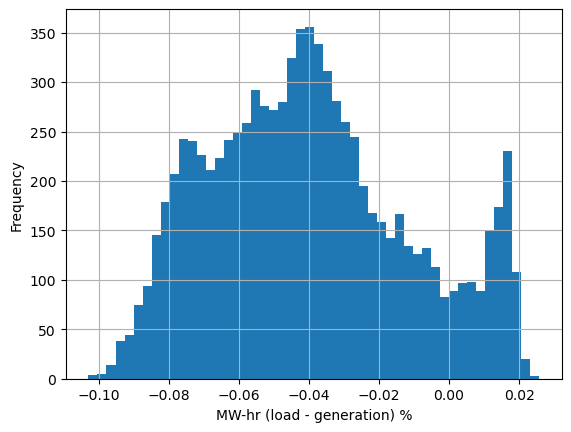

In [33]:
ax = (100* (n.loads_t.p_set.sum(axis=1) - tot_gen) / n.loads_t.p_set.sum(axis=1)).hist(bins=50)
ax.set_xlabel('MW-hr (load - generation) %')
ax.set_ylabel('Frequency')

In [39]:
n.stores

,bus,carrier,e_nom,e_cyclic,e_nom_opt,type,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,...,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime
Store,,,,,,,,,,,,,,,,,,,,,
BC_ALH_RES Reservoir Store,BC_ALH_RES Water Bus,Water,8.760000e+09,True,8.760000e+09,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
Mica/Columbia,Mica/Columbia Water Bus,water,1.000000e+15,False,1.000000e+15,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_ALU_RES Reservoir Store,BC_ALU_RES Water Bus,Water,1.986500e+08,True,1.986500e+08,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_BR0_RES Reservoir Store,BC_BR0_RES Water Bus,Water,1.012500e+09,True,1.012500e+09,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_GMS_RES Reservoir Store,BC_GMS_RES Water Bus,Water,3.947100e+10,True,3.947100e+10,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_JHT_RES Reservoir Store,BC_JHT_RES Water Bus,Water,2.042000e+07,True,2.042000e+07,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
Campbell,Campbell Water Bus,water,1.000000e+15,False,1.000000e+15,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_LAJ_RES Reservoir Store,BC_LAJ_RES Water Bus,Water,7.056000e+08,True,7.056000e+08,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf
BC_LDR_RES Reservoir Store,BC_LDR_RES Water Bus,Water,3.096000e+08,True,3.096000e+08,,False,0.0,inf,0.0,...,False,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf


In [35]:
n.stores_t.e

Store,BC_ALH_RES Reservoir Store,BC_ALU_RES Reservoir Store,BC_BR0_RES Reservoir Store,BC_GMS_RES Reservoir Store,BC_JHT_RES Reservoir Store,BC_LAJ_RES Reservoir Store,BC_LDR_RES Reservoir Store,BC_MCA_RES Reservoir Store,BC_PCN_RES Reservoir Store,BC_REV_RES Reservoir Store,...,BC_SON_RES Reservoir Store,BC_STC_RES Reservoir Store,BC_WGS_RES Reservoir Store,Bridge,Campbell,Global NG Store,Mica/Columbia,Peace,Seven Mile,Stave
snapshot,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,8.757300e+09,1.174125e+08,7.511683e+08,3.507230e+10,1.776280e+07,4.955642e+08,2.867275e+08,7.848275e+09,1.560033e+07,1.313517e+08,...,9.544427e+06,165000000.0,9.531595e+07,5.139360e+05,4.464000e+05,0.0,1.908000e+06,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-01 01:00:00,8.760000e+09,1.173726e+08,7.504953e+08,3.506822e+10,1.792084e+07,4.954020e+08,2.861513e+08,7.848731e+09,2.061166e+07,1.275269e+08,...,1.002551e+07,127992000.0,9.532404e+07,1.027872e+06,8.928000e+05,0.0,3.816000e+06,3.700800e+07,5.302800e+06,0.000000e+00
2021-01-01 02:00:00,8.728282e+09,1.173338e+08,7.507582e+08,3.506916e+10,1.747444e+07,4.952398e+08,2.861796e+08,7.847273e+09,1.347646e+07,1.222349e+08,...,9.570556e+06,135127200.0,9.533211e+07,1.541808e+06,1.339200e+06,0.0,4.352400e+07,3.700800e+07,5.302800e+06,1.252800e+06
2021-01-01 03:00:00,8.728361e+09,1.172951e+08,7.510183e+08,3.506301e+10,1.763248e+07,4.950776e+08,2.863149e+08,7.847729e+09,1.342613e+07,1.210337e+08,...,9.115002e+06,105254400.0,9.534019e+07,2.055744e+06,1.785600e+06,0.0,4.543200e+07,7.401600e+07,5.302800e+06,1.252800e+06
2021-01-01 04:00:00,8.734443e+09,1.172661e+08,7.503355e+08,3.506214e+10,1.823692e+07,4.949155e+08,2.864516e+08,7.848183e+09,8.096346e+06,1.138279e+08,...,9.595534e+06,112389600.0,9.534827e+07,2.569680e+06,1.785600e+06,0.0,4.734000e+07,7.401600e+07,5.302800e+06,2.505600e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,8.748222e+09,1.177575e+08,7.519872e+08,3.509735e+10,1.668424e+07,4.961805e+08,2.868833e+08,7.869418e+09,1.344474e+07,1.233871e+08,...,9.914133e+06,136459200.0,9.539997e+07,3.957829e+09,2.767018e+09,0.0,3.718837e+10,3.411504e+10,2.227258e+10,6.699456e+08
2021-12-31 20:00:00,8.754111e+09,1.176812e+08,7.512943e+08,3.509617e+10,1.684228e+07,4.960214e+08,2.870148e+08,7.864110e+09,8.666446e+06,1.219160e+08,...,1.040343e+07,143594400.0,9.540791e+07,3.958343e+09,2.767464e+09,0.0,3.719028e+10,3.411504e+10,2.227789e+10,6.699456e+08
2021-12-31 21:00:00,8.760000e+09,1.176048e+08,7.506014e+08,3.509026e+10,1.744672e+07,4.958623e+08,2.871462e+08,7.861554e+09,8.616118e+06,1.176936e+08,...,1.089275e+07,150729600.0,9.541585e+07,3.958857e+09,2.767464e+09,0.0,3.719219e+10,3.411504e+10,2.227789e+10,6.699456e+08


In [38]:
n.links[n.links.index.str.contains("ALH")]

,bus0,bus1,carrier,efficiency,p_nom,marginal_cost,min_up_time,min_down_time,ramp_limit_up,ramp_limit_down,...,capital_cost,length,terrain_factor,committable,start_up_cost,shut_down_cost,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
BC_ALH_GSS Store Link,BC_ALH_GSS Water Bus,BC_ALH_RES Water Bus,Water,1.000000,8.760000e+09,0.000000,0,0,1.0,1.0,...,0.0,0.0,1.0,False,0.0,0.0,1,0,1.0,1.0
BC_ALH_GSS Release Link,BC_ALH_RES Water Bus,BC_ALH_GSS Water Bus,Water,1.000000,7.412434e+10,0.000000,0,0,1.0,1.0,...,0.0,0.0,1.0,False,0.0,0.0,1,0,1.0,1.0
BC_ALH_GSS Discharge Link,BC_ALH_GSS Water Bus,CentralKootenay,Water,0.000097,1.908000e+06,0.000181,0,0,1.0,1.0,...,0.0,0.0,1.0,False,0.0,0.0,1,0,1.0,1.0
BC_ALH_GSS Spill Link,BC_ALH_GSS Water Bus,Mica/Columbia Water Bus,Water,1.000000,3.780000e+07,0.000001,0,0,1.0,1.0,...,0.0,0.0,1.0,False,0.0,0.0,1,0,1.0,1.0


In [ ]:
n.l

In [42]:
n.generators.index[n.generators.index.str.contains('Inflow')]

Index(['BC_ALH_RES Inflow Generator', 'BC_ALU_RES Inflow Generator',
       'BC_BR0_RES Inflow Generator', 'BC_GMS_RES Inflow Generator',
       'BC_JHT_RES Inflow Generator', 'BC_LAJ_RES Inflow Generator',
       'BC_LDR_RES Inflow Generator', 'BC_MCA_RES Inflow Generator',
       'BC_PCN_RES Inflow Generator', 'BC_REV_RES Inflow Generator',
       'BC_RUS_RES Inflow Generator', 'BC_SCA_RES Inflow Generator',
       'BC_SEV_RES Inflow Generator', 'BC_SFL_RES Inflow Generator',
       'BC_SON_RES Inflow Generator', 'BC_STC_RES Inflow Generator',
       'BC_WGS_RES Inflow Generator', 'BC_WDN_RES Inflow Generator',
       'BC_WHN_RES Inflow Generator'],
      dtype='object', name='Generator')

In [56]:
n.links_t.p0["BC_ALH_GSS Store Link"][0]

0.0

In [67]:
e0 = n.stores_t.e["BC_MCA_RES Reservoir Store"][-1] # last = initial
inflow = n.generators_t.p['BC_MCA_RES Inflow Generator'][0]
release = n.links_t.p0["BC_MCA_GSS Release Link"][0]
e0 - release + inflow

7848274604.98395

In [68]:
n.stores_t.e["BC_MCA_RES Reservoir Store"][0]

7848274604.98395

In [63]:
n.stores_t.e["BC_ALH_RES Reservoir Store"][0] -  (e0 - release + inflow)

126703.42986488342

In [66]:
n.links_t.p0["BC_ALH_GSS Release Link"][0]

1908000.0

In [69]:
n.lines['bus0'] == CowichanValle)

,type,bus0,bus1,length,v_nom,s_nom,x,r,b,carrier,...,lifetime,terrain_factor,num_parallel,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
SHA_JCT_GOW_DSS,520,CowichanValley,Capital,30.00,300.0,10000.0,11.43000,5.196000,0.000100,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
KSH_JCT_GOW_DSS,520,CowichanValley,Capital,40.36,300.0,10000.0,15.37716,6.990352,0.000135,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
SHA_JCT_GTP_DSS,725,CowichanValley,Capital,40.92,300.0,10000.0,14.81304,4.317060,0.000137,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
ARN_DSS_GLS_JCT,375,GreaterVancouver,Capital,38.17,300.0,10000.0,15.34434,10.485299,0.000127,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
SAL_JCT_VIT_TSS,375,Capital,CowichanValley,15.00,300.0,10000.0,6.03000,4.120500,0.000050,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEE_TSS_VNT_TSS_1,1055,CentralOkanagan,NorthOkanagan,42.50,300.0,10000.0,14.32250,2.473500,0.000142,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
DGB_DSS_RGA_DSS,1055,CentralOkanagan,Okanagan-Similkameen,42.50,300.0,10000.0,14.32250,2.473500,0.000142,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
LEE_TSS_VNT_TSS_2,1055,CentralOkanagan,NorthOkanagan,42.50,300.0,10000.0,14.32250,2.473500,0.000142,AC,...,inf,1.0,1.0,-inf,inf,,0.0,0.0,0.0,0.0
